# Multivariate CoxPH-Lasso Validation

```{contents}
```

Here we will validate the CoxPH-Lasso model on the validation set. We will use the same hyperparameters as the ones found in the previous notebook.

## Load Data

In [1]:
import pandas as pd
from source.cox_lasso_functions import *

input_path = '../Data/Intermediate_Files/'
output_path = '../Data/Processed_Data/'

raw_coefs = pd.read_csv(output_path + 'multivariate_cox_lasso/ewas_cog_os_raw_coefs.csv', index_col=0)
mean_coefs = set_cutoff(coefs=raw_coefs,threshold=0.95)

df_validation = pd.read_pickle(
    input_path+'df_validation.pkl')[mean_coefs.index]

validation_clinical_data = pd.read_csv(input_path+'validation_clinical_data.csv',
                                       low_memory=False, index_col=0)

print(
    f' Dataset (df) contains {df_validation.shape[1]} columns (5mC nucleotides/probes) and {df_validation.shape[0]} rows (samples).')

 Dataset (df) contains 35 columns (5mC nucleotides/probes) and 201 rows (samples).


## Transform to M-values

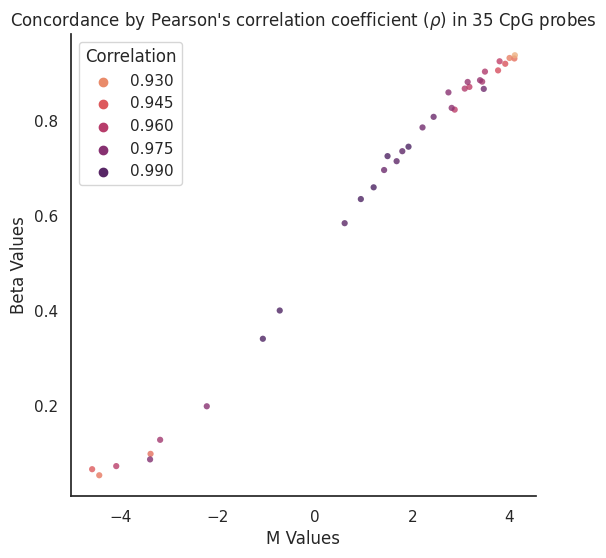

In [2]:
import math
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

def beta2m(val):
    '''Transfrom beta-values into m-values'''
    return math.log2(val/(1-val))

x_test_m = df_validation.apply(np.vectorize(beta2m))

# Get correlation between Beta and M Values
corr = x_test_m.corrwith(df_validation, axis=0)

# Glue them into same dataframe for vizualization purposes
beta_to_m_values = pd.concat([x_test_m.mean(),df_validation.mean(),corr],axis=1,
                             keys=['M Values','Beta Values','Correlation'],
                             join= 'inner')

def draw_scatterplot(df,x,y,hue,s):
    
    # Define theme

    sns.set_theme(style="white")
    f, ax = plt.subplots(figsize=(6, 6))
    sns.despine(f, left=False, bottom=False)

    # Define scatterplot

    sns.scatterplot(x=x, y=y,
                    hue=hue, palette='flare', s=s,
                    sizes=(1, 8), linewidth=0, alpha=0.8,
                    data=df, ax=ax)

    # Calculate Pearson’s correlation coefficient (r)
    # and its two-tailed p-value (p)

    r,p = stats.pearsonr(df[x],df[y])

    # Annotate r and p into the plot

    plt.annotate(fr'$\rho$: {r:.5f}, p-value: {p:.5f}',
                xy=(6.0, 0.01), xycoords='data',
                ha='right', va='center',
                bbox={'boxstyle': 'round', 'facecolor': 'none',
                'edgecolor': 'lightgray'})

    # Define plot specs

    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(r"Concordance by Pearson's correlation coefficient ($\rho$) in " + str(len(df)) + ' CpG probes',
               fontsize = 12) 

    # Save plot figure
    
    # plt.savefig('../Figures/Beta_to_M_Values_' + str(len(df)) + '_scatterplot' + '.png',
    #              bbox_inches='tight', dpi=300)

    return(plt.show())

draw_scatterplot(df=beta_to_m_values,x='M Values',y='Beta Values',hue='Correlation',s=20)

## Standardize Data

Here we will use the same scaler as the one used in the previous notebook (discovery cohort).

In [3]:
def standardize_data(df, reference_df):
    """Standardize data using mean and standard deviation of reference dataset"""

    # Keep only columns that are in both datasets
    reference_df = reference_df.loc[:, df.columns]

    # Standardize data
    df_z = (df - reference_df.mean()) / reference_df.std()

    return df_z

# Read top CpGs selected from previous code file (univariate cox-ph EWAS)
ewas_top_cpgs = pd.read_csv(output_path+'ewas_dmr/ewas_top_cpgs.csv', index_col=0)

# Standardize data
x_test_m_z = standardize_data(df= x_test_m, reference_df= ewas_top_cpgs)

## Generate Model Results

### Validation dataset

In [4]:
score_name = 'MethylScoreAML_Px'

df_test, threshold = generate_coxph_score(coef_mean=mean_coefs,
                                        x=x_test_m_z,
                                        df=validation_clinical_data,
                                        score_name=score_name,
                                        train_test=0.2208,
                                        rpart_outcome='os.time')


Continuous score cut at the value of 0.2208 for ['Normal', 't (9;11)', '11q23', 'inv (16)', 'Miscell', 't (8;21)', 'Insuff', nan]


Text(0.5, 1.0, 'Distribution of MethylScoreAML_Px in StJude trials')

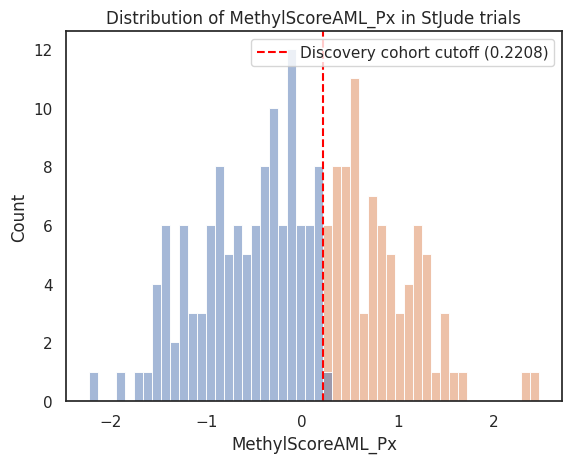

In [5]:
sns.histplot(data=df_test,x=score_name, bins=50, hue = score_name + ' Categorical' )

# add vertical line at threshold and third quartile
plt.axvline(threshold ,color='red', linestyle='--')


# add legend
plt.legend({'Discovery cohort cutoff' + ' (' + str(threshold) + ')',})
plt.title('Distribution of ' + score_name + ' in StJude trials')

### Kaplan-Meier Plots

#### Overall study population

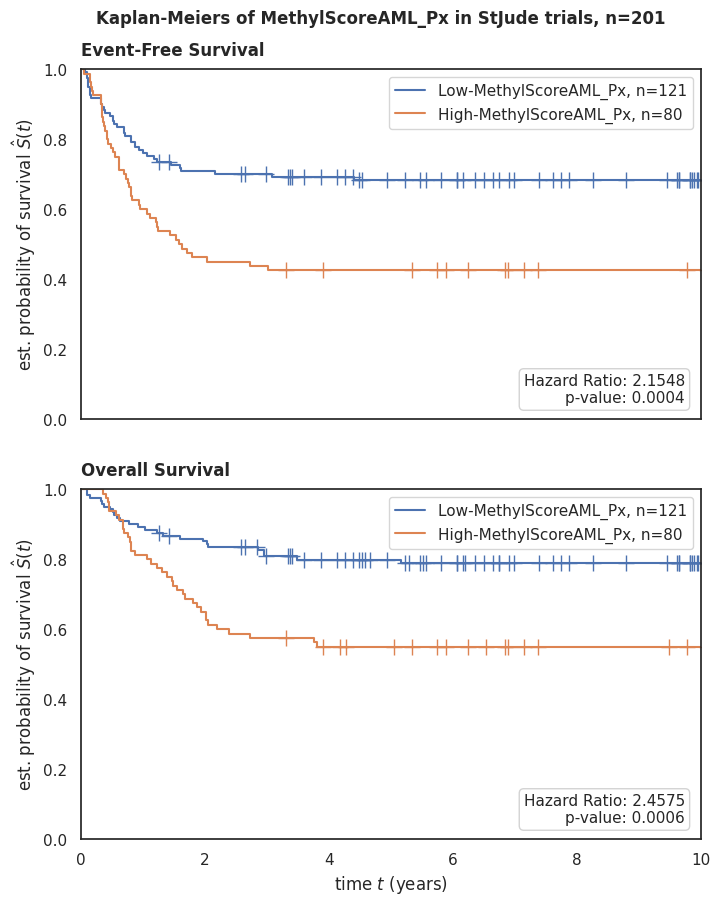

In [6]:
# Import Plotting Functions
from source.data_visualization_functions import *

draw_kaplan_meier(scorename=score_name,
                        df=df_test,
                        save_plot=False,
                        add_risk_counts=False,
                        trialname='StJude trials')

#### Per risk group

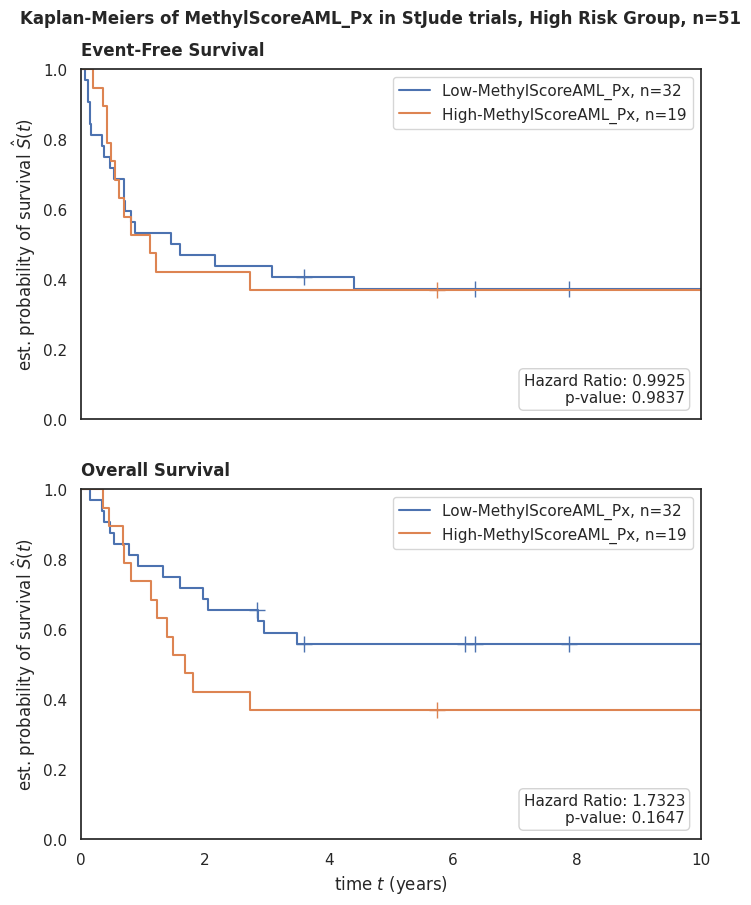

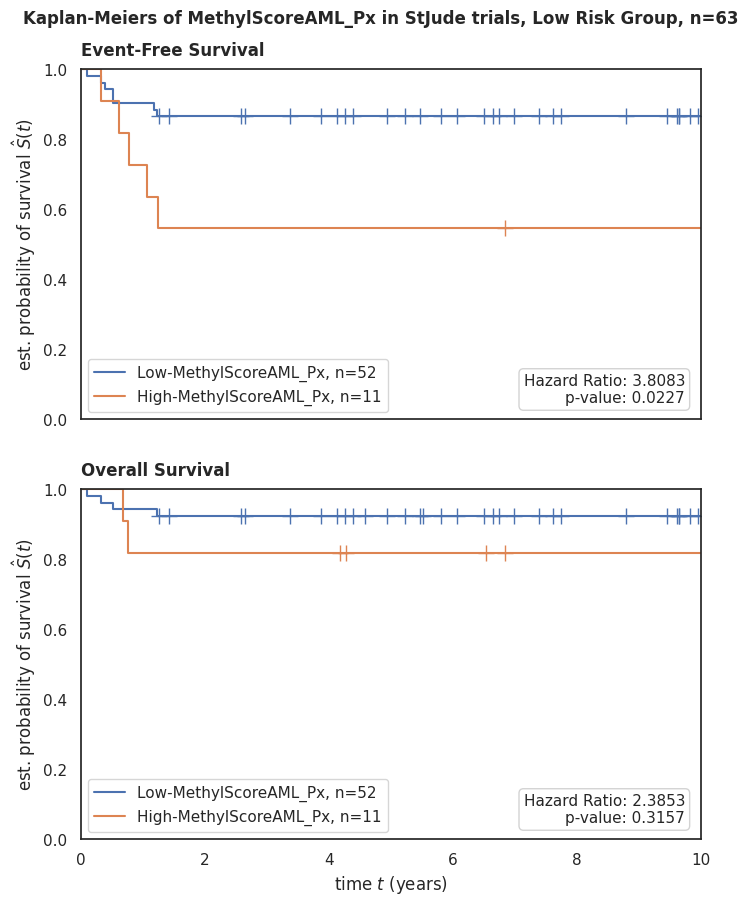

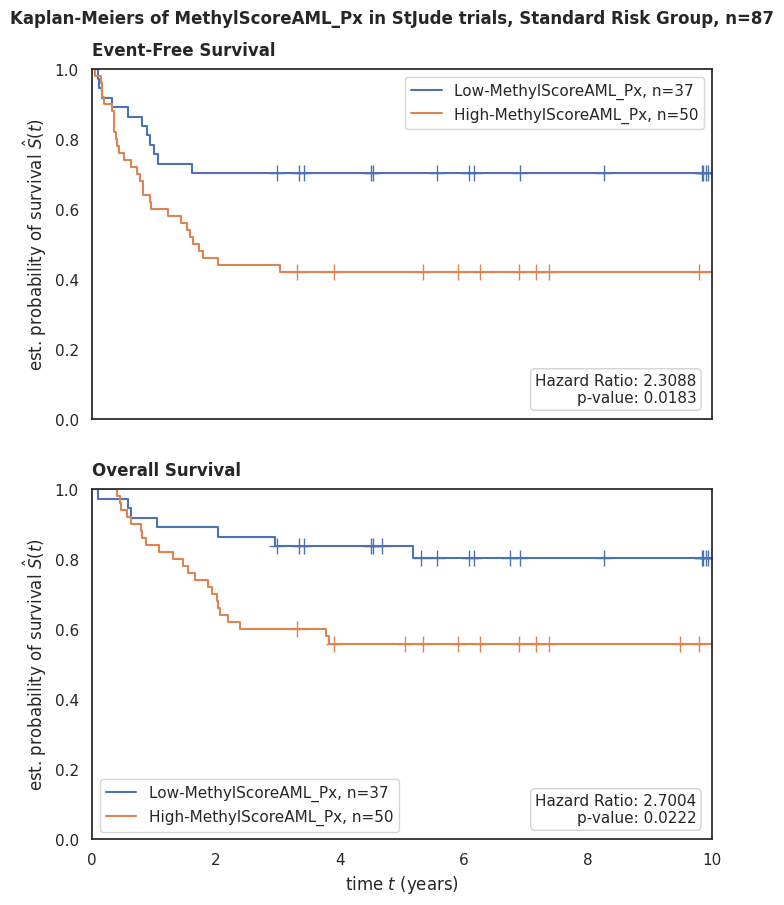

In [7]:
draw_kaplan_meier(scorename=score_name,
                        df=df_test[df_test['Risk Group'] == 'High Risk'],
                        save_plot=False,
                        add_risk_counts=False,
                        trialname='StJude trials, High Risk Group')

draw_kaplan_meier(scorename=score_name,
                        df=df_test[df_test['Risk Group'] == 'Low Risk'],
                        save_plot=False,
                        add_risk_counts=False,
                        trialname='StJude trials, Low Risk Group')

draw_kaplan_meier(scorename=score_name,
                        df=df_test[df_test['Risk Group'] == 'Standard Risk'],
                        save_plot=False,
                        add_risk_counts=False,
                        trialname='StJude trials, Standard Risk Group')

### Forest Plots

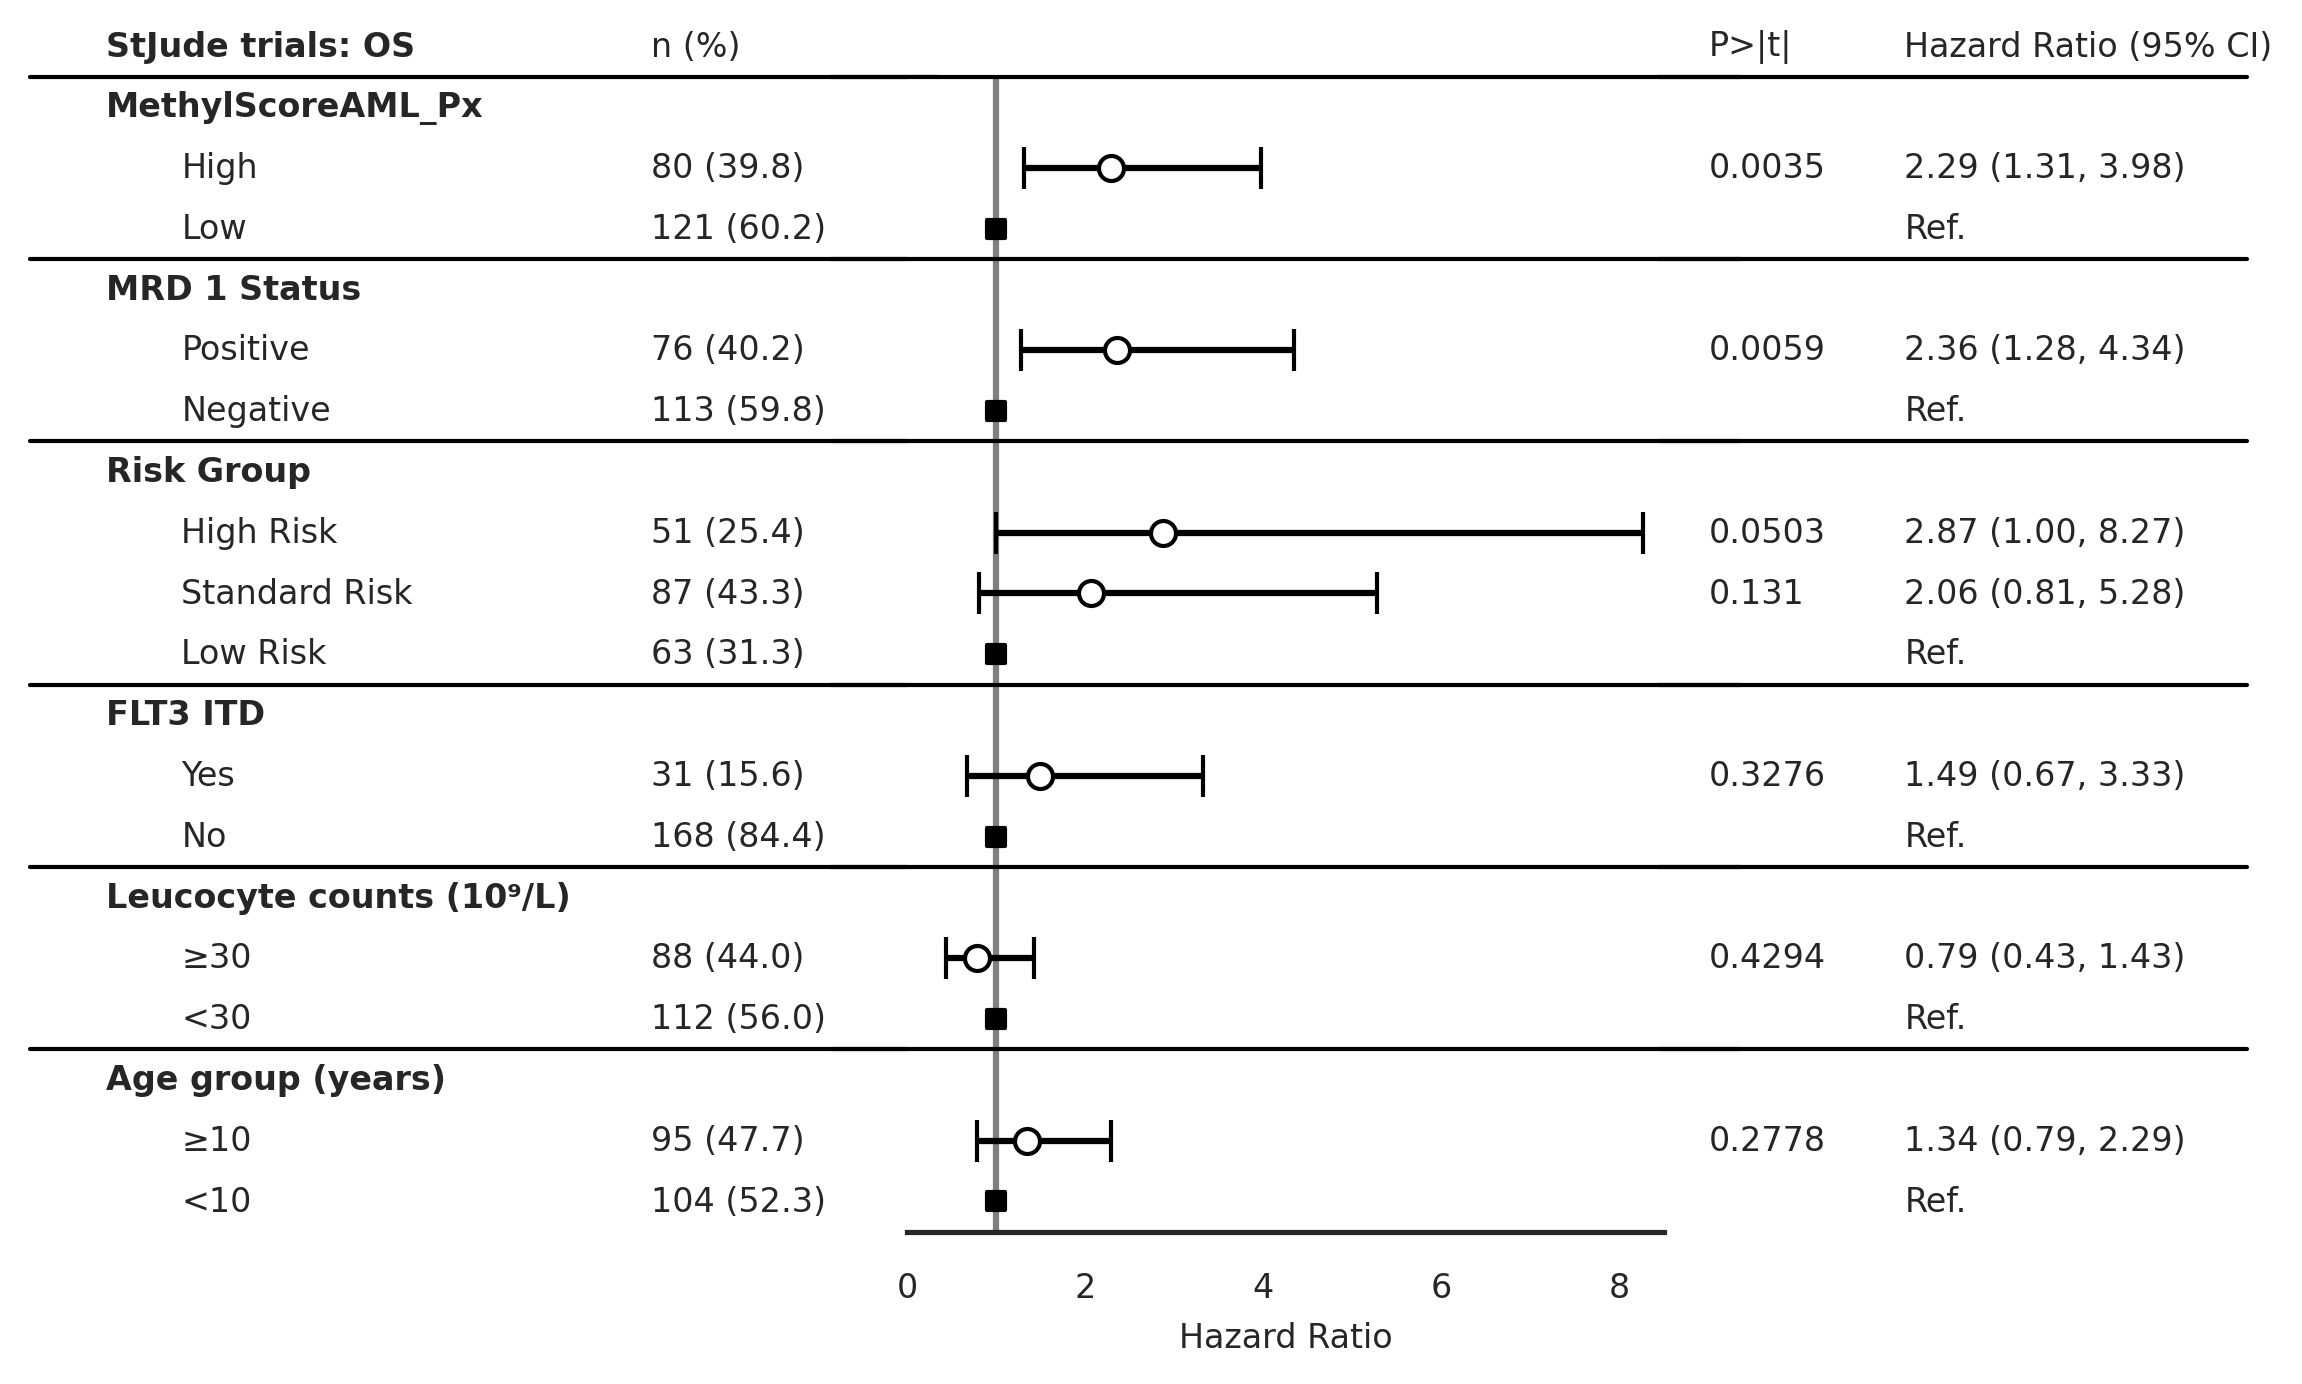

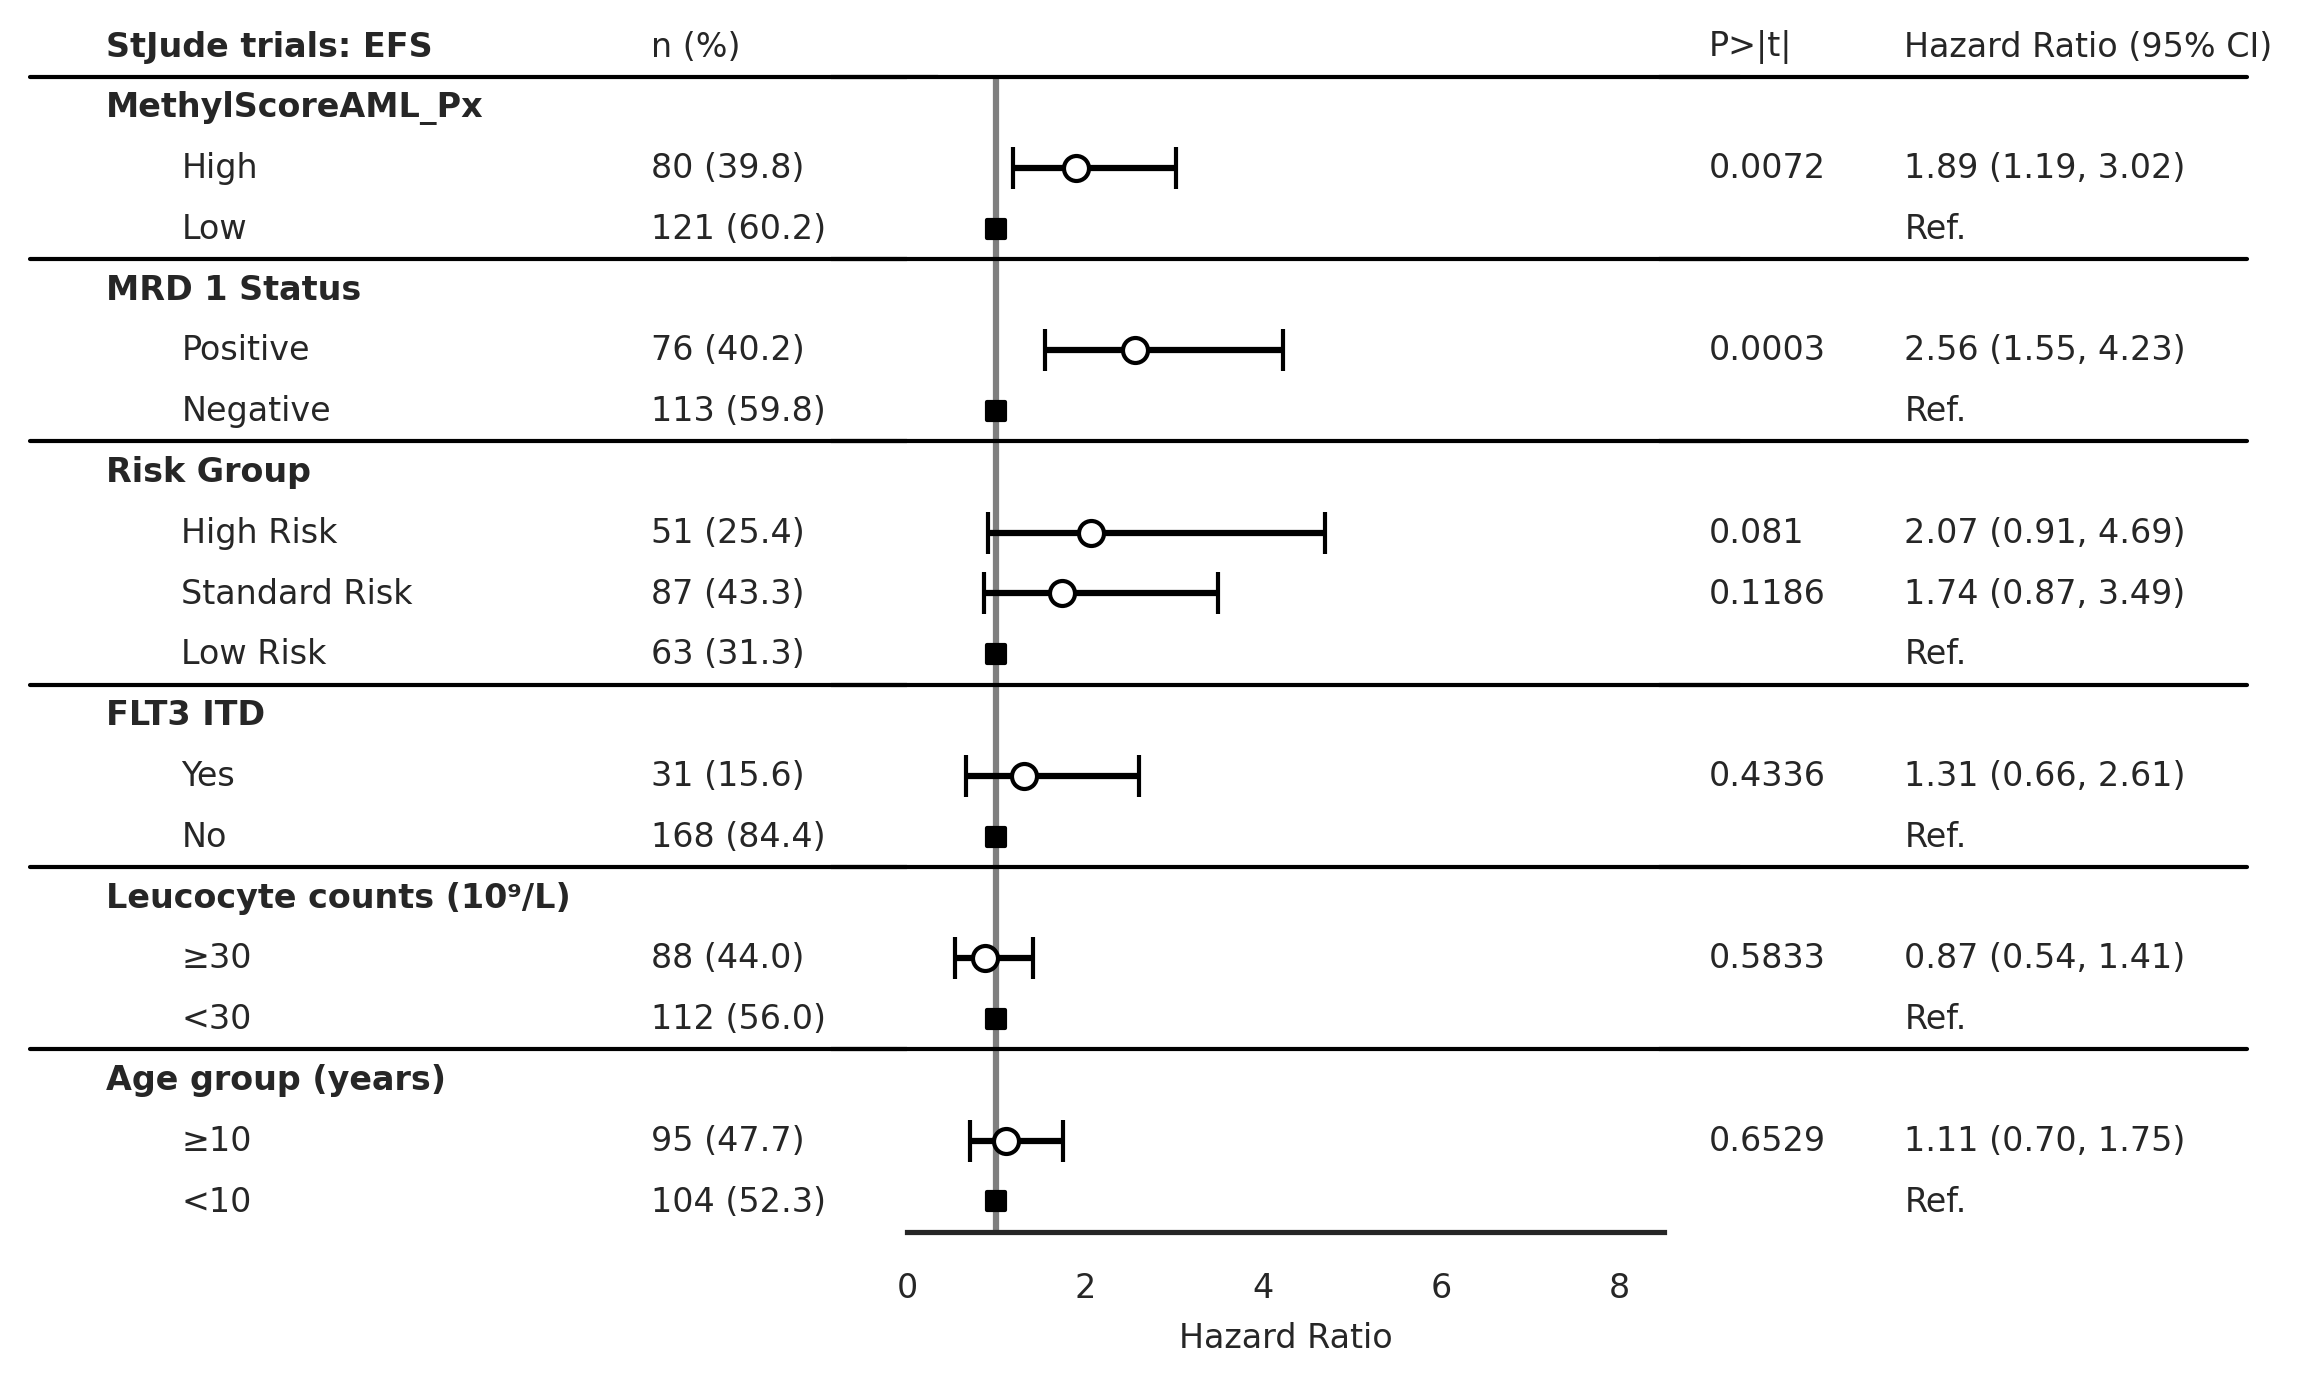

In [8]:
draw_forest_plot(time='os.time',
                    event='os.evnt',
                    df=df_test,
                    trialname='StJude trials:',
                    scorename=score_name,
                    save_plot=False)

draw_forest_plot(time='efs.time',
                    event='efs.evnt',
                    df=df_test,
                    trialname='StJude trials:',
                    scorename=score_name,
                    save_plot=False)

### Box Plots

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

High Risk vs. Standard Risk: Kruskal-Wallis independent samples (pairwise between groups) with Bonferroni correction, P_val:3.150e-01 Stat=2.628e+00
Standard Risk vs. Low Risk: Kruskal-Wallis independent samples (pairwise between groups) with Bonferroni correction, P_val:8.551e-11 Stat=4.428e+01
High Risk vs. Low Risk: Kruskal-Wallis independent samples (pairwise between groups) with Bonferroni correction, P_val:2.836e-07 Stat=2.848e+01


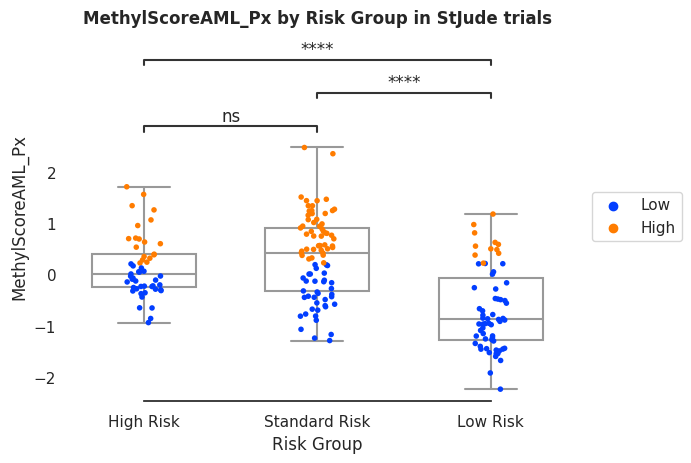

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Positive vs. Negative: Kruskal-Wallis independent samples (pairwise between groups) with Bonferroni correction, P_val:1.003e-01 Stat=2.701e+00


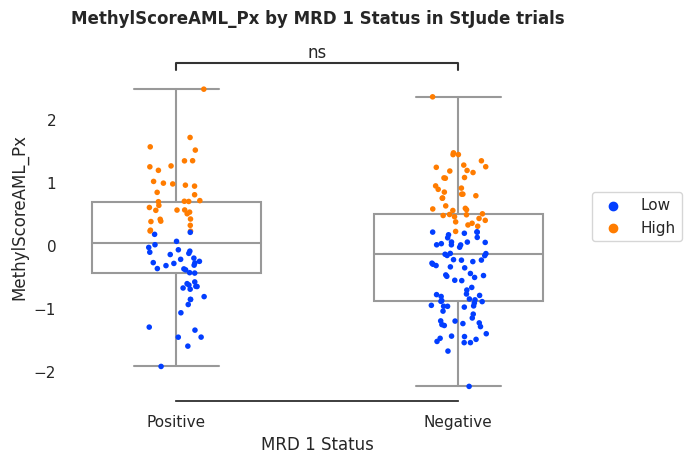

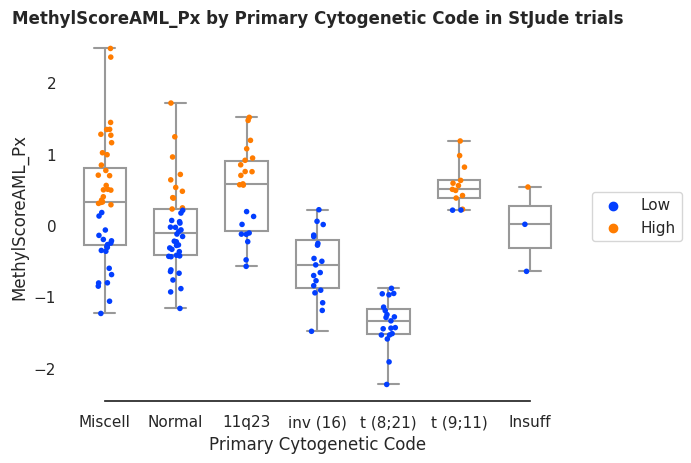

In [9]:
draw_boxplot(df=validation_clinical_data,x='Risk Group', y=score_name,
                order=['High Risk', 'Standard Risk', 'Low Risk'],
                trialname='StJude trials', hue=score_name + ' Categorical',
                save_plot=False, figsize=None)

draw_boxplot(df=validation_clinical_data,x='MRD 1 Status', y=score_name,
                order=['Positive','Negative'],
                trialname='StJude trials', hue=score_name + ' Categorical',
                save_plot=False, figsize=None)

draw_boxplot(df=validation_clinical_data,x='Primary Cytogenetic Code', y=score_name,
                order='auto',
                trialname='StJude trials', hue=score_name + ' Categorical',
                save_plot=False, figsize=None)

### Stacked Bar Plots

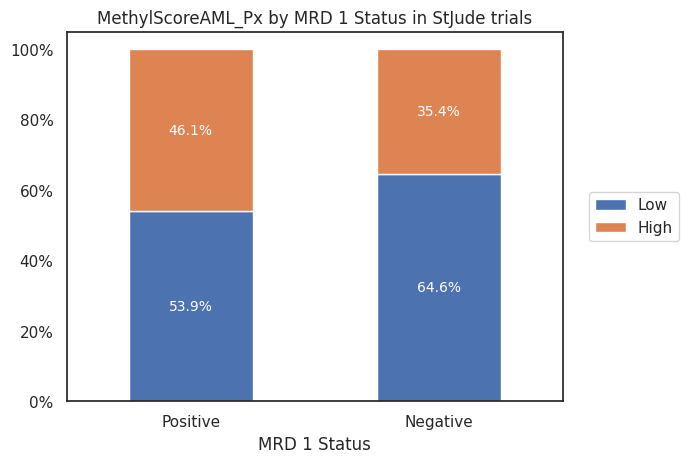

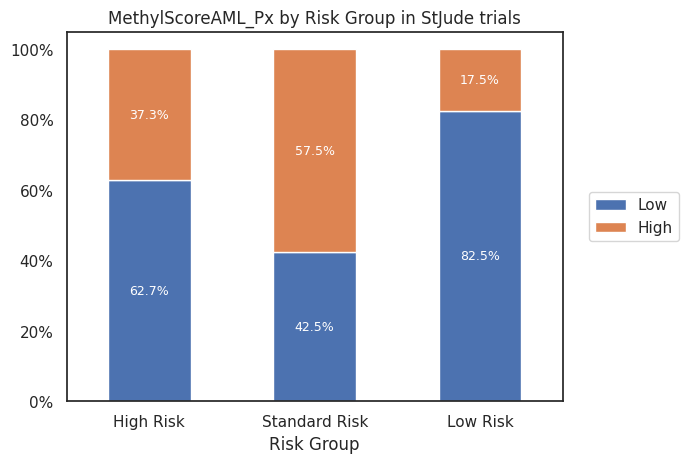

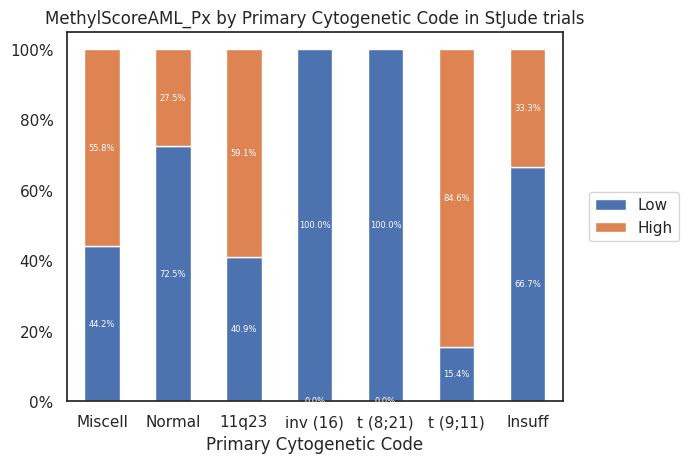

In [10]:
draw_stacked_barplot(df=validation_clinical_data,x='MRD 1 Status', y=score_name,
             order=['Positive','Negative'],
             trialname='StJude trials', hue=score_name + ' Categorical',
             save_plot=False, figsize=None)

draw_stacked_barplot(df=validation_clinical_data,x='Risk Group', y=score_name,
                order=['High Risk', 'Standard Risk', 'Low Risk'],
                trialname='StJude trials', hue=score_name + ' Categorical',
                save_plot=False, figsize=None, fontsize=9)

draw_stacked_barplot(df=validation_clinical_data,x='Primary Cytogenetic Code', y=score_name,
                order='auto',
                trialname='StJude trials', hue=score_name + ' Categorical',
                save_plot=False, figsize=None, fontsize=6)



### Patient Characteristics Table

In [14]:
from tableone import TableOne

columns = ['Age (years)','Age group (years)','Sex','Race or ethnic group',
            'Hispanic or Latino ethnic group', 'MRD 1 Status',
            'Leucocyte counts (10⁹/L)', 'BM Leukemic blasts (%)',
            'Risk Group', 'Clinical Trial','FLT3 ITD']

validation_clinical_data['Age (years)'] = validation_clinical_data['Age (years)'].astype(float)

mytable_cog = TableOne(validation_clinical_data, columns,
                        overall=False, missing=True,
                        pval=False, pval_adjust=False,
                        htest_name=True,dip_test=True,
                        tukey_test=True, normal_test=True,

                        order={'FLT3 ITD':['Yes','No'],
                                'Race or ethnic group':['White','Black or African American','Asian'],
                                'MRD 1 Status': ['Positive'],
                                'Risk Group': ['High Risk', 'Standard Risk'],
                                'FLT3 ITD': ['Yes'],
                                'Leucocyte counts (10⁹/L)': ['≥30'],
                                'Age group (years)': ['≥10']})

mytable_cog.to_csv(output_path + 'multivariate_cox_lasso/tableone_validation_cohort.csv')

mytable_cog.tabulate(tablefmt="html", 
                        headers=[score_name,"",'Missing','Validation Cohort'])

MethylScoreAML_Px,,Missing,Validation Cohort
n,,,201
"Age (years), mean (SD)",,2,8.8 (6.0)
"Age group (years), n (%)",≥10,2,95 (47.7)
,<10,,104 (52.3)
"Sex, n (%)",Female,0,87 (43.3)
,Male,,114 (56.7)
"Race or ethnic group, n (%)",White,2,143 (71.9)
,Black or African American,,32 (16.1)
,Asian,,1 (0.5)
,Native Hawaiian or other Pacific Islander,,2 (1.0)


In [15]:
from tableone import TableOne

columns = ['Age (years)','Age group (years)','Sex','Race or ethnic group',
            'Hispanic or Latino ethnic group', 'MRD 1 Status',
            'Leucocyte counts (10⁹/L)', 'BM Leukemic blasts (%)',
            'Risk Group', 'Clinical Trial','FLT3 ITD']

validation_clinical_data['Age (years)'] = validation_clinical_data['Age (years)'].astype(float)

mytable_cog = TableOne(validation_clinical_data, columns,
                        overall=False, missing=True,
                        pval=True, pval_adjust=False,
                        htest_name=True,dip_test=True,
                        tukey_test=True, normal_test=True,

                        order={'FLT3 ITD':['Yes','No'],
                                'Race or ethnic group':['White','Black or African American','Asian'],
                                'MRD 1 Status': ['Positive'],
                                'Risk Group': ['High Risk', 'Standard Risk'],
                                'FLT3 ITD': ['Yes'],
                                'Leucocyte counts (10⁹/L)': ['≥30'],
                                'Age group (years)': ['≥10']},
                        groupby=score_name + ' Categorical')

mytable_cog.to_csv(output_path + 'multivariate_cox_lasso/tableone_validation_methylscoreaml_px.csv')

mytable_cog.tabulate(tablefmt="html", 
                        headers=[score_name,"",'Missing','High','Low','p-value','Statistical Test'])

MethylScoreAML_Px,,Missing,High,Low,p-value,Statistical Test
n,,,121,80,,
"Age (years), mean (SD)",,2,9.5 (5.6),7.6 (6.4),0.034,Two Sample T-test
"Age group (years), n (%)",≥10,2,61 (50.8),34 (43.0),0.351,Chi-squared
,<10,,59 (49.2),45 (57.0),,
"Sex, n (%)",Female,0,46 (38.0),41 (51.2),0.088,Chi-squared
,Male,,75 (62.0),39 (48.8),,
"Race or ethnic group, n (%)",White,2,87 (71.9),56 (71.8),0.740,Chi-squared (warning: expected count < 5)
,Black or African American,,19 (15.7),13 (16.7),,
,Asian,,,1 (1.3),,
,Native Hawaiian or other Pacific Islander,,1 (0.8),1 (1.3),,


## Watermark

In [14]:
%load_ext watermark

In [15]:
# watermark with all libraries used in this notebook
%watermark -v -p pandas,seaborn,matplotlib,tableone,sklearn,lifelines,statannotations -a Francisco_Marchi@Lamba_Lab_UF -d -m

Author: Francisco_Marchi@Lamba_Lab_UF

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 8.12.2

pandas         : 2.0.2
seaborn        : 0.12.2
matplotlib     : 3.7.1
tableone       : 0.7.12
sklearn        : 1.2.2
lifelines      : 0.27.7
statannotations: 0.5.0

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.15.90.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

